In [40]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/_global_clusters.csv"

df = pd.read_csv(fpath)
df.head()

,Unnamed: 0,cellId,cellType,sampleInfo
0,0,AAACGAACAGCAGTAG.1_ND,B cells,ND
1,1,AAAGAACGTCTACAGT.1_ND,Mac1,ND
2,2,AAAGAACTCCTCGCAT.1_ND,Mac1,ND
3,3,AAAGGGCGTTAGGGTG.1_ND,Mac3,ND
4,4,AACAAAGAGTATAGGT.1_ND,Monocytes,ND


In [25]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

X = []
obs = []

for key in keys:
    print(f"{key}...")

    # get annotations
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    lf['cellId'] = lf['cellId'].apply(lambda x: x + f"_{key}")
    lf = lf.drop_duplicates(subset='cellId')

    # get raw expression
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    rf.index = rf.index + f"_{key}"

    lf = lf[lf['cellId'].isin(rf.index)]
    rf = rf.reindex(lf['cellId'])

    print(f"{rf.shape=} {lf.shape=}")

    X.append(rf)
    obs.append(lf)

X = pd.concat(X)
obs = pd.concat(obs)
obs = obs.set_index('cellId')

print(f"{X.shape=} {obs.shape=}")

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
rf.shape=(1261, 31053) lf.shape=(1261, 6)
HFD8...
rf.shape=(6123, 31053) lf.shape=(6123, 6)
HFD14...
rf.shape=(6436, 31053) lf.shape=(6436, 6)
X.shape=(13820, 31053) obs.shape=(13820, 5)


In [34]:
var = pd.DataFrame(X.columns)
var.columns = ['gene_name']
var['index'] = var['gene_name'].copy()
var = var.set_index('index')
var.head()

,gene_name
index,
XKR4,XKR4
GM1992,GM1992
GM37381,GM37381
RP1,RP1
SOX17,SOX17


In [35]:
adata = sc.AnnData(X, var=var, obs=obs)
adata

/tmp/ipykernel_1829017/1777137724.py:1: FutureWarning: X.dtype being converted to np.float32 from object. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X, var=var, obs=obs)


AnnData object with n_obs × n_vars = 13820 × 31053
    obs: 'cellType', 'sampleInfo', 'x', 'y', 'colors'
    var: 'gene_name'

In [36]:
outpath = '/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/anndata_object/all_cells.h5ad'
adata.write(outpath, compression='gzip')
print('done')

done


In [37]:
test = sc.read(outpath)
test

AnnData object with n_obs × n_vars = 13820 × 31053
    obs: 'cellType', 'sampleInfo', 'x', 'y', 'colors'
    var: 'gene_name'

In [38]:
test.obs.head()

,cellType,sampleInfo,x,y,colors
cellId,,,,,
AAACGAACAGCAGTAG.1_ND,B cells,ND,6.783486,1.839065,#9e0142
AAAGAACGTCTACAGT.1_ND,Mac1,ND,3.089298,-1.726030,#fdbf6f
AAAGAACTCCTCGCAT.1_ND,Mac1,ND,3.614130,-1.571004,#fdbf6f
AAAGGGCGTTAGGGTG.1_ND,Mac3,ND,3.086352,6.166065,#fdbf6f
AACAAAGAGTATAGGT.1_ND,Monocytes,ND,3.178745,4.929769,#ffffbe


<AxesSubplot: xlabel='x', ylabel='y'>

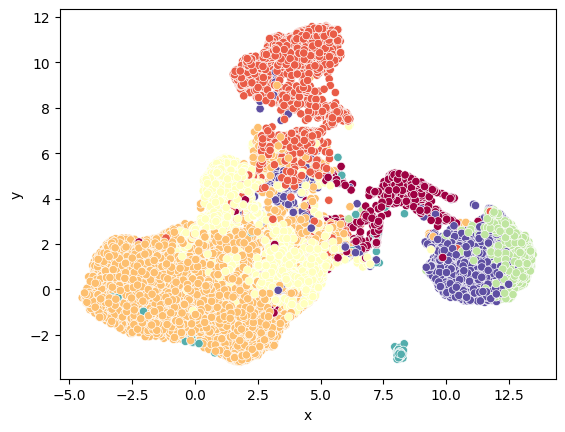

In [43]:
sns.scatterplot(data=test.obs, 
                x='x',
                y='y',
                c=test.obs['colors'].to_list())